## Weather forecast using Deep Learning Multi-variable LSTM-MLP Model

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras import layers
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

DATA_PATH = "../data/"
reset_graph()

Using TensorFlow backend.


In [2]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
#warnings.filterwarnings("ignore", category=WARNING) 
print(sys.version)
print(tf.__version__)
print(tf.keras.__version__)
print(pd.__version__)

3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
1.13.1
2.2.4-tf
0.24.2


In [3]:
n_inputs = 5 # input temperature
n_lstm_neurons = 150 #neurons in rnn/lstm hidden layer
n_dense_neurons = 200
n_steps = 12 # features or time steps for time series for 2 days 6 hrs lag value to forcast
n_outputs = 5 # output temperature
n_layers = 5
n_learning_rate = 0.001
batch_size = 360 # 36 cities, 10 hrs of each city
n_epochs = 5000
city_cnt = 36

# initialize a list to store test results
test_ar = []

In [4]:
# read 'weather_all.csv'  dataset as a dataframe
weather_df = pd.read_csv(DATA_PATH + 'weather_all.csv', low_memory =  False)
# Convert index column to datetime dtype.
weather_df.datetime = pd.to_datetime(weather_df.datetime, infer_datetime_format = True)
weather_df.set_index('datetime', inplace = True)
print(weather_df.shape)
#print(weather_df.info(verbose = True, null_counts = True))

weather_df_Array = weather_df.values

weather_vals = weather_df_Array[:,0:city_cnt * n_inputs]

loc_vals = weather_df_Array[:,city_cnt * n_inputs:]

Columns = weather_df.columns
print(weather_vals.shape, loc_vals.shape)
print(Columns)

(44460, 252)
(44460, 180) (44460, 72)
Index(['Vancouver.temperature', 'Vancouver.pressure', 'Vancouver.humidity',
       'Vancouver.wind_speed', 'Vancouver.wind_direction',
       'Portland.temperature', 'Portland.pressure', 'Portland.humidity',
       'Portland.wind_speed', 'Portland.wind_direction',
       ...
       'Tel Aviv District.latitude', 'Tel Aviv District.longitude',
       'Eilat.latitude', 'Eilat.longitude', 'Haifa.latitude',
       'Haifa.longitude', 'Nahariyya.latitude', 'Nahariyya.longitude',
       'Jerusalem.latitude', 'Jerusalem.longitude'],
      dtype='object', length=252)


In [5]:
## split a multi-variate sequence into samples
def split_mul_sequences(ar, n_steps1, n_inputs1):
    ts_length = ar.shape[0] - n_steps1 -1
    print(ts_length)
    Ts = np.empty([ts_length * city_cnt, (n_steps1 + 1), n_inputs1 ])

    Ts_Entry = np.empty([n_inputs1, (n_steps1 + 1)])
    print(ar.shape, Ts_Entry.shape)
    for i in range(ts_length):
        for k in range(city_cnt):
            for j in range(n_inputs1):
                Ts_Entry[j] = ar.T[k * n_inputs1 + j][i: i + n_steps1+1]
                    
            Ts[i * city_cnt + k ] = Ts_Entry.T
    X = Ts[:, :-1]
    y = Ts[:, 1:]    

    print('X shape', X.shape)
    print('y shape', y.shape)
    
    # expected input data shape: (batch_size, n_timesteps, n_inputs)
    # expected output data shape: (batch_size, n_outputs)
    #y = y.reshape(-1, n_inputs1)

    return X, y

def split_location_sequences(ar, n_steps1):
    ts_length = ar.shape[0] - n_steps1 -1

    loc_input = np.empty([ts_length * city_cnt, n_steps1, 2])
    for i in range(ts_length):
        for j in range(n_steps1):
            for k in range(city_cnt):
                loc_input[i * city_cnt + k][j][0] = ar[0][k * 2]
                loc_input[i * city_cnt + k][j][1] = ar[0][k * 2 + 1]

    print('loc_input shape', loc_input.shape)
    return loc_input



X, y = split_mul_sequences(weather_vals, n_steps, n_inputs)
location = split_location_sequences(loc_vals, n_steps)

train_size =  X.shape[0] - batch_size - 48  #test_size * city_cnt
train_size = ((int)(train_size/batch_size)) * batch_size
print('train_size ', train_size)
test_size = batch_size

X_train = X[:train_size]
y_train = y[:train_size]
loc_train = location[:train_size]

X_test = X[train_size:train_size + test_size]
y_test = y[train_size:train_size + test_size]
loc_test = location[train_size:train_size + test_size]

print('X_train ', X_train.shape, y_train.shape)
print('X_test', X_test.shape, y_test.shape)
print('location ', loc_train.shape, loc_test.shape)

# All data needs to be scaled to a small range like 0 to 1 for the neural
# network to work well. Create scalers for the inputs and outputs.

X_scaler = MinMaxScaler(feature_range=(0.1, 1.1))
y_scaler = MinMaxScaler(feature_range=(0.1, 1.1))
loc_scaler = MinMaxScaler(feature_range=(0.1, 1.1))

X_train_scaled = X_scaler.fit_transform(X_train.reshape(train_size,-1)).reshape(train_size,n_steps,n_inputs)
X_test_scaled = X_scaler.transform(X_test.reshape(test_size,-1)).reshape(test_size,n_steps,n_inputs)

y_train_scaled = y_scaler.fit_transform(y_train.reshape(train_size,-1)).reshape(train_size,n_steps, n_inputs)
y_test_scaled = y_scaler.transform(y_test.reshape(test_size,-1)).reshape(test_size,n_steps,n_inputs)

loc_train_scaled = loc_scaler.fit_transform(loc_train.reshape(train_size,-1)).reshape(train_size,n_steps, 2)
loc_test_scaled = loc_scaler.transform(loc_test.reshape(test_size,-1)).reshape(test_size,n_steps,2)

print('X_train_scaled ', X_train_scaled.shape, y_train_scaled.shape)
print('X_test_scaled ', X_test_scaled.shape, y_test_scaled.shape)
print('location_scaled ', loc_train_scaled.shape, loc_test_scaled.shape)


44447
(44460, 180) (5, 13)
X shape (1600092, 12, 5)
y shape (1600092, 12, 5)
loc_input shape (1600092, 12, 2)
train_size  1599480
X_train  (1599480, 12, 5) (1599480, 12, 5)
X_test (360, 12, 5) (360, 12, 5)
location  (1599480, 12, 2) (360, 12, 2)
X_train_scaled  (1599480, 12, 5) (1599480, 12, 5)
X_test_scaled  (360, 12, 5) (360, 12, 5)
location_scaled  (1599480, 12, 2) (360, 12, 2)


In [6]:
print('Build model...')

input_1 = tf.keras.layers.Input(shape=(n_steps, n_inputs), dtype='float32')
input_2 = tf.keras.layers.Input(shape=(n_steps, 2), dtype='float32')

lstm_output_1 = tf.keras.layers.LSTM(300, 
                           activation = 'relu', 
                           return_sequences=True)(input_1)


batch_norm_out_1 = tf.layers.BatchNormalization()(lstm_output_1)
dropout_1 = tf.layers.Dropout(0.01)(batch_norm_out_1)


lstm_output_2 = tf.keras.layers.LSTM(150, 
                           activation = 'relu', 
                           return_sequences=True)(dropout_1)
batch_norm_out_2 = tf.layers.BatchNormalization()(lstm_output_2)
dropout_2 = tf.layers.Dropout(0.01)(batch_norm_out_2)

lstm_output_3 = tf.keras.layers.LSTM(200, 
                           activation = 'relu', 
                           return_sequences=True)(dropout_2)
batch_norm_out_3 = tf.layers.BatchNormalization()(lstm_output_3)
dropout_3 = tf.layers.Dropout(0.01)(batch_norm_out_3)

lstm_output_4 = tf.keras.layers.LSTM(150, 
                           activation = 'relu', 
                           return_sequences=True)(dropout_1)
batch_norm_out_4 = tf.layers.BatchNormalization()(lstm_output_4)
dropout_4 = tf.layers.Dropout(0.01)(batch_norm_out_4)

lstm_output_5 = tf.keras.layers.LSTM(300, 
                           activation = 'relu', 
                           return_sequences=True)(dropout_4)
batch_norm_out_5 = tf.layers.BatchNormalization()(lstm_output_5)
dropout_5 = tf.layers.Dropout(0.01)(batch_norm_out_5)

merged = tf.keras.layers.concatenate([dropout_5, input_2])

print('merged', merged.shape)

merged_output1 = tf.layers.Dense(300, activation='relu')(merged)
merged_output2 = tf.layers.Dense(n_outputs, activation='relu')(merged_output1)

print('merged_output1 ', merged_output1)
model = tf.keras.Model(inputs = [input_1, input_2], outputs = merged_output2)

model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(n_learning_rate), metrics=['mse', 'mae', 'mape'])

Build model...
Instructions for updating:
Colocations handled automatically by placer.
merged (?, 12, 302)
merged_output1  Tensor("dense/Relu:0", shape=(?, 12, 300), dtype=float32)
Instructions for updating:
Use tf.cast instead.


In [7]:
strategy = tf.distribute.MirroredStrategy()
config = tf.estimator.RunConfig(train_distribute=strategy, save_checkpoints_steps = 1000)

def train_input_fn():
    dx = tf.data.Dataset.from_tensor_slices((X_train_scaled, loc_train_scaled))
    dy = tf.data.Dataset.from_tensor_slices((y_train_scaled))
    dataset = tf.data.Dataset.zip((dx, dy))
    dataset = dataset.shuffle(buffer_size = train_size)
    dataset = dataset.repeat(50)
    dataset = dataset.batch(batch_size, drop_remainder = True)
    return dataset

estimator = tf.keras.estimator.model_to_estimator(model, config=config, model_dir='multivar_lstm_with_loc_model1/')
estimator.train(input_fn=train_input_fn, steps=n_epochs)

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Configured nccl all-reduce.
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Using config: {'_protocol': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f418f30fb38>, '_service': None, '_model_dir': 'multivar_lstm_with_loc_model1/', '_num_ps_replicas': 0, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    m

INFO:tensorflow:global_step/sec: 9.13083
INFO:tensorflow:loss = 0.009427331, step = 3600 (10.950 sec)
INFO:tensorflow:global_step/sec: 8.83915
INFO:tensorflow:loss = 0.0097465385, step = 3700 (11.313 sec)
INFO:tensorflow:global_step/sec: 8.89093
INFO:tensorflow:loss = 0.010495435, step = 3800 (11.247 sec)
INFO:tensorflow:global_step/sec: 8.93621
INFO:tensorflow:loss = 0.010164773, step = 3900 (11.191 sec)
INFO:tensorflow:Saving checkpoints for 4000 into multivar_lstm_with_loc_model1/model.ckpt.
INFO:tensorflow:global_step/sec: 4.65444
INFO:tensorflow:loss = 0.009813165, step = 4000 (21.485 sec)
INFO:tensorflow:global_step/sec: 8.83516
INFO:tensorflow:loss = 0.010341266, step = 4100 (11.318 sec)
INFO:tensorflow:global_step/sec: 9.03749
INFO:tensorflow:loss = 0.010047463, step = 4200 (11.065 sec)
INFO:tensorflow:global_step/sec: 9.06956
INFO:tensorflow:loss = 0.010364583, step = 4300 (11.025 sec)
INFO:tensorflow:global_step/sec: 9.14824
INFO:tensorflow:loss = 0.009767521, step = 4400 (10

In [8]:
def test_input_fn():
    dx = tf.data.Dataset.from_tensor_slices((X_test_scaled, loc_test_scaled))
    dy = tf.data.Dataset.from_tensor_slices((y_test_scaled))
    dataset = tf.data.Dataset.zip((dx, dy))
    dataset = dataset.batch(batch_size, drop_remainder = True)
    return dataset

result = estimator.evaluate(input_fn=test_input_fn, steps = 1)

print("loss (test-set):", result)
    
y_pred = estimator.predict(input_fn=test_input_fn)
mape = result['mean_absolute_percentage_error']
mae = result['mean_absolute_error']
rmse = np.sqrt(result['mean_squared_error'])

print(y_pred)
test_ar.append({'label':'DL-LSTM-MLP', 'mape' : mape, 'mae': mae,'rmse':rmse})  

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21T05:28:42Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from multivar_lstm_with_loc_model1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-06-21-05:28:43
INFO:tensorflow:Saving dict for global step 5000: global_step = 5000, loss = 0.013046932, mean_absolute_error = 0.052294813, mean_absolute_percentage_error = 16.01995, mean_squared_error = 0.013046932
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: multivar_lstm_with_loc_model1/model.ckpt-5000
loss (test-set): {'global_step': 5000, 'mean_absolute_error': 0.052294813, 'mean_absolute_percentage_error': 16.01995, 'mean_squared_error': 0.013046932, 'loss': 

In [9]:
print(test_ar)

[{'rmse': 0.11422317, 'mae': 0.052294813, 'mape': 16.01995, 'label': 'DL-LSTM-MLP'}]


In [10]:
predict_scaled = list(y_pred)
print(len(predict_scaled))
predict_ar = np.array(predict_scaled)
#print(predict_ar[0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from multivar_lstm_with_loc_model1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
360


In [11]:
y_pred_scaled = np.empty([predict_ar.shape[0], n_steps, n_inputs])
for i in range(predict_ar.shape[0]):
    predict_val = list(predict_ar[i].values())
    y_pred_scaled[i] = predict_val[0].reshape(predict_val[0].shape[0], -1)
y_pred_scaled = y_pred_scaled.reshape(predict_ar.shape[0], n_steps, n_inputs)
print(y_pred_scaled.shape)
print(y_test_scaled.shape)

(360, 12, 5)
(360, 12, 5)


sequence_test  (36, 5, 10, 12)
(360, 12, 5) (360, 12, 5)
(36, 5, 10, 12)


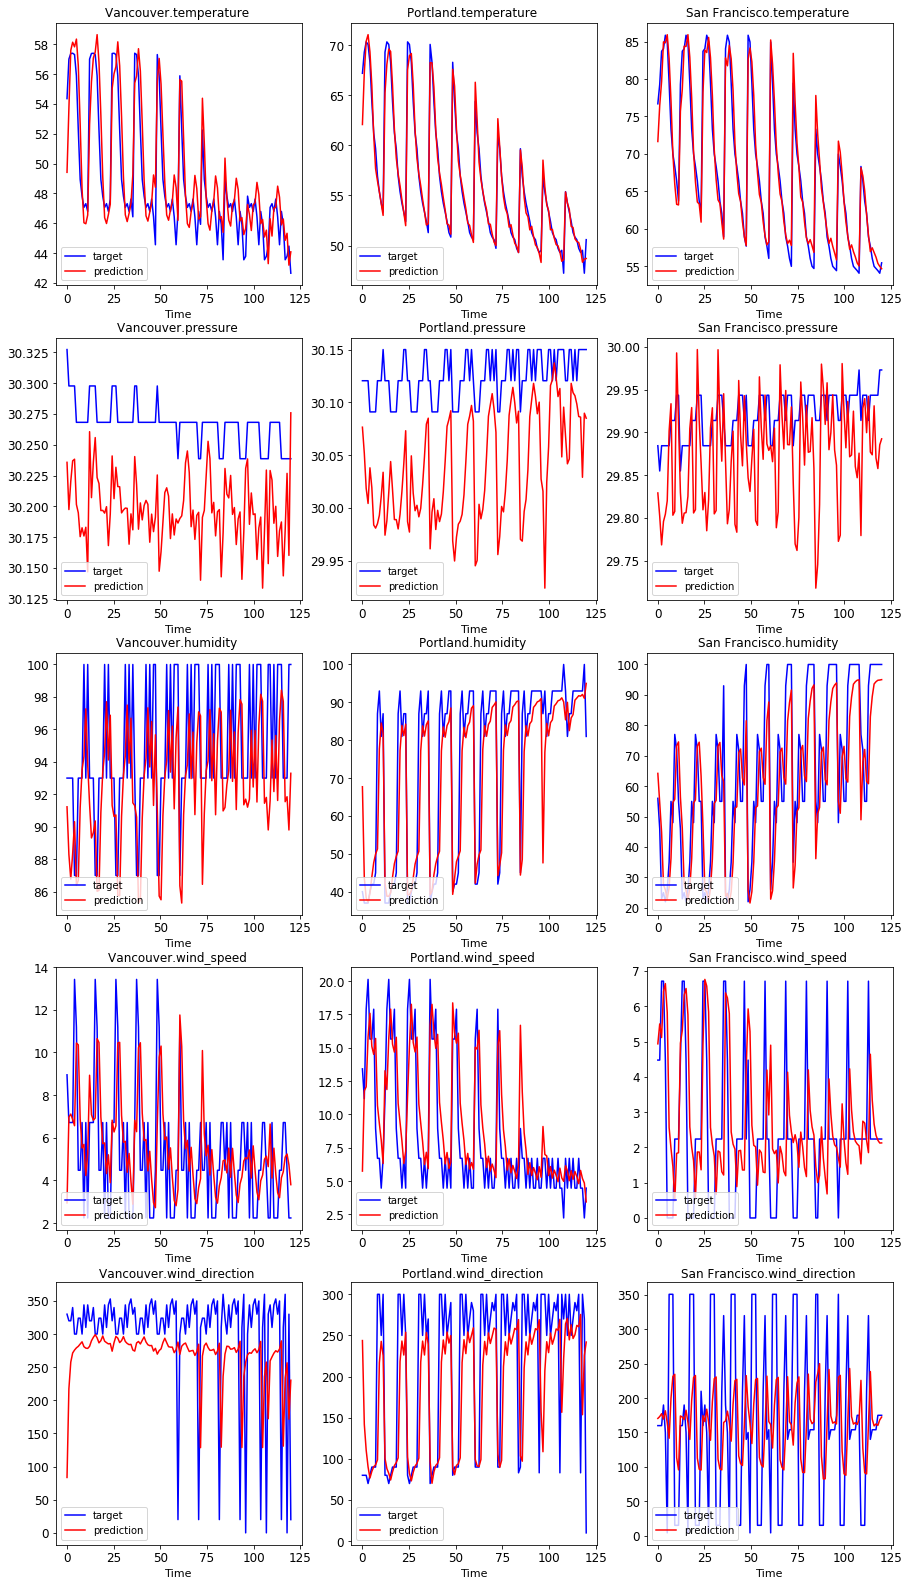

In [12]:
iterations = (int)(batch_size / city_cnt)
sequence_pred = np.empty([city_cnt, n_inputs, iterations, n_steps])
sequence_test = np.empty([city_cnt, n_inputs, iterations, n_steps])
print('sequence_test ', sequence_test.shape)

def plot_predictions(sequence_test, sequence_pred):
    
    plt.rcParams["figure.figsize"] = [15, 28]
    f, ax = plt.subplots(5, 3, sharex = False, sharey = False)
    
       
    for i in range(3):  # plot 3 cities
        for j in range(n_inputs):
            p_sequence = sequence_pred[i][j].flatten()
            t_sequence = sequence_test[i][j].flatten()
        
            t_instance = np.linspace(0, len(t_sequence), len(t_sequence)).reshape(-1, 1)
            row = j
            col = i

            axes = ax[row][col]
            city_str = Columns[i * n_inputs + j]
            
            str = "%s " % (city_str)
            axes.set_title(str, fontsize=12)

            axes.plot(t_instance, t_sequence, "b", markersize=10, label="target")
            axes.plot(t_instance, p_sequence, "r", markersize=10, label="prediction")

            axes.legend(loc="lower left")
            axes.set_xlabel("Time", fontsize=11)
            
    plt.show()
print(y_test_scaled.shape, y_pred_scaled.shape)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled.reshape(batch_size, -1)).reshape(batch_size, n_steps, n_inputs)
y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled.reshape(batch_size, -1)).reshape(batch_size, n_steps, n_inputs)

for s in range(batch_size):
    city = (int)(s%city_cnt)
    index = (int)(s/city_cnt)
    for col in range(n_inputs):
        sequence_test[city][col][index] = y_test_unscaled[s].T[col]
        sequence_pred[city][col][index] = y_pred_unscaled[s].T[col]

print(sequence_test.shape)
plot_predictions(sequence_test, sequence_pred) 